In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns=200
pd.options.display.max_columns=300

In [3]:
# read data
data = pd.read_csv('day.csv')
data.shape
data.head()

(730, 16)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Data Preparation

#### Data Summaries

No Missing values

In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [5]:
df_data = data.copy()

#### Add New Vars

In [6]:
# add interation variables
df_data['temp_diff'] = df_data['atemp'] - df_data['temp']
df_data['temp_ratio'] = df_data['atemp'] / df_data['temp']
df_data['hum_x_temp'] = df_data['hum'] * df_data['temp']
df_data['hum_by_temp'] = df_data['hum'] / df_data['temp']
df_data['wind_x_temp'] = df_data['windspeed'] * df_data['temp']
df_data['wind_by_temp'] = df_data['windspeed'] / df_data['temp']
df_data['hum_x_wind'] = df_data['hum'] * df_data['windspeed']
df_data['hum_by_wind'] = df_data['hum'] / df_data['windspeed']

#### Outliers

Outliers are within acceptable range.

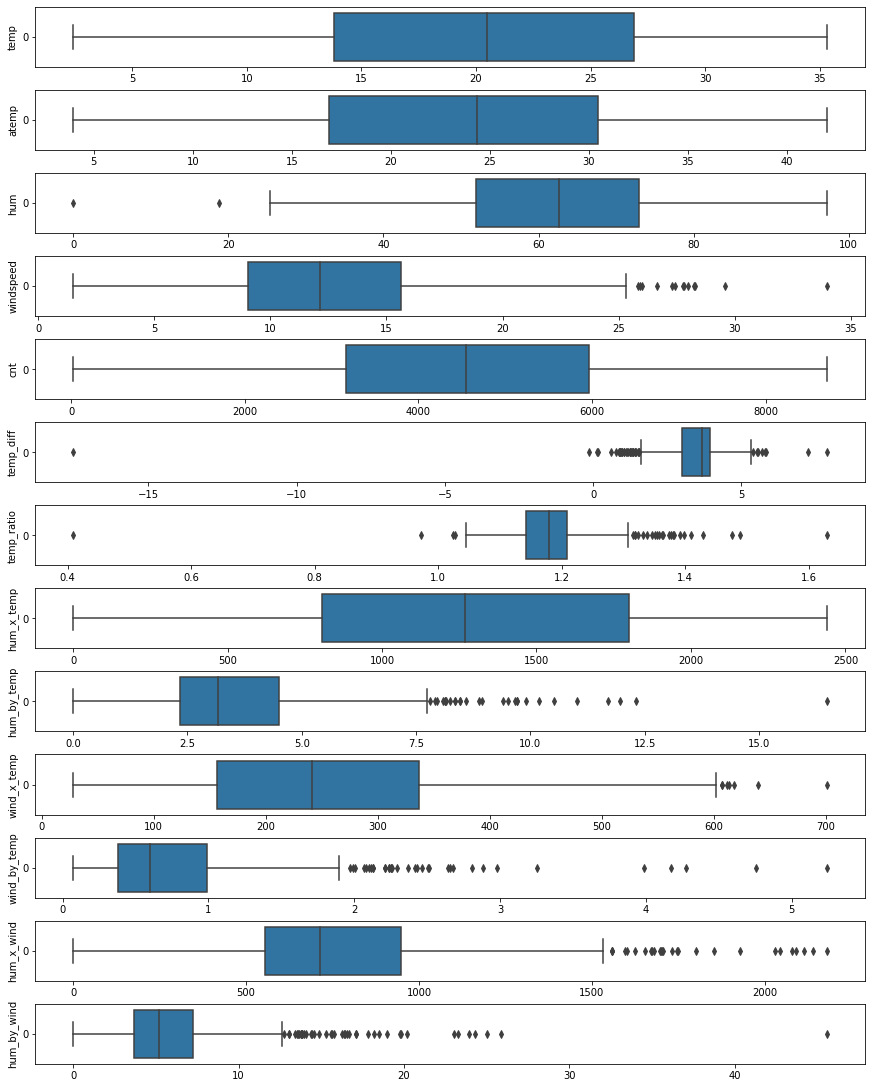

In [7]:
# plot outliers
fig, ax = plt.subplots(13, 1, figsize=[12, 15], constrained_layout=True)
for idx, col in enumerate(['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'temp_diff', 'temp_ratio',
                            'hum_x_temp', 'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind', 'hum_by_wind']):
    sns.boxplot(data=df_data[col], orient='h', ax=ax[idx])
    ax[idx].set_ylabel(col)
pass;

#### Clean Outliers

In [8]:
df_data = df_data.loc[df_data['temp_diff'] >= -5]
df_data = df_data.loc[df_data['temp_diff'] <= 7]
df_data = df_data.loc[df_data['temp_ratio'] <= 1.5]
df_data = df_data.loc[df_data['wind_by_temp'] <= 5]
df_data = df_data.loc[df_data['hum_by_wind'] <= 30]

In [9]:
print(f'Original Data Shape: {data.shape}')
print(f'Data Shape after Outlier removal: {df_data.shape}')

Original Data Shape: (730, 16)
Data Shape after Outlier removal: (724, 24)


#### Clean Categorical Vars

There seems to be a mismatch between dteday and weekday, workingday. Might drop dteday.

#### Cleaning Continous Vars

In [10]:
# not needed

#### Bin Continous Vars

In [11]:
# bin numerical into categorical
for col in ['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'temp_diff', 'temp_ratio',
            'hum_x_temp', 'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind', 'hum_by_wind']:
    df_data[f'{col}_binned'] = pd.cut(df_data[col], 5, labels=['very low', 'low', 'medium', 'high', 'very high'])

#### Correlation Plot

<AxesSubplot:>

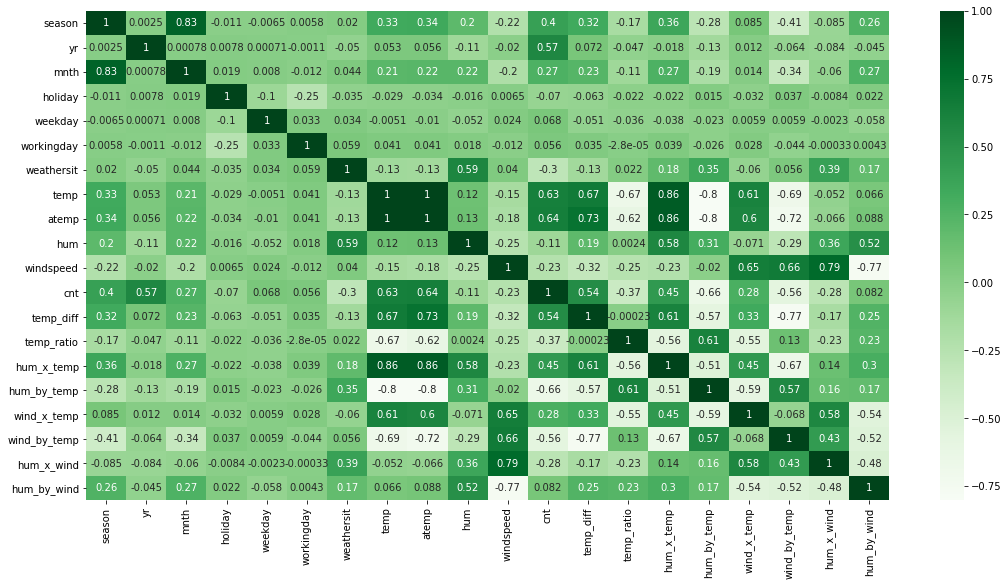

In [12]:
# correlation
ax, fig = plt.subplots(figsize=[18,9])
plot_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt', 
       'temp_diff', 'temp_ratio','hum_x_temp', 'hum_by_temp', 'wind_x_temp', 
       'wind_by_temp', 'hum_x_wind', 'hum_by_wind']
sns.heatmap(data=df_data[plot_cols].corr(), annot=True, cmap='Greens')

## EDA

### Univariate

#### Distributions

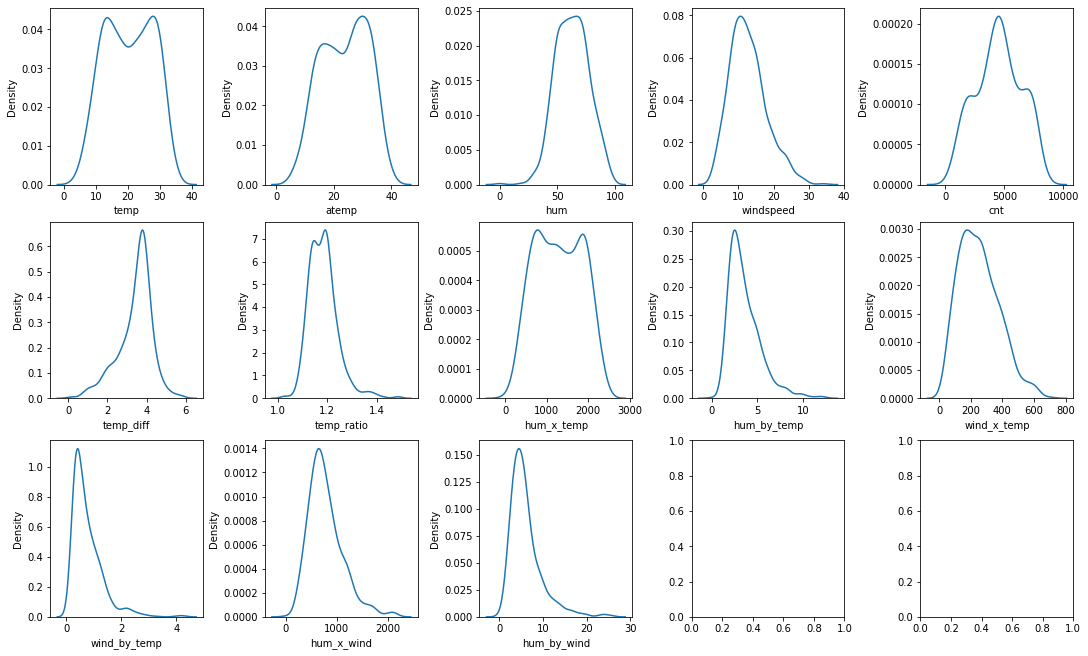

In [13]:
# distributions of continous vars
fig, ax = plt.subplots(3, 5, figsize=[15, 9], constrained_layout=True)
plot_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'temp_diff', 'temp_ratio', 
             'hum_x_temp', 'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind', 'hum_by_wind']
for idx, col in enumerate(plot_cols):
    sns.kdeplot(data=df_data, x=col, ax=ax[idx//5, idx%5])
pass;

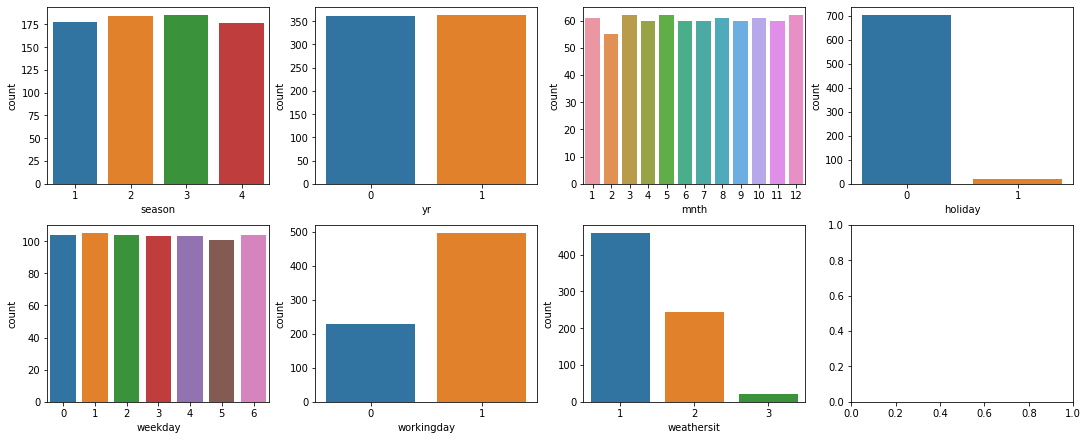

In [14]:
# distributions of categorical vars
fig, ax = plt.subplots(2, 4, figsize=[15, 6], constrained_layout=True)
plot_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
for idx, col in enumerate(plot_cols):
    sns.countplot(data=df_data, x=col, ax=ax[idx//4, idx%4])
pass;

### Multivariate

#### Pairplot

In [15]:
# sns.pairplot(data=df_data[['temp', 'atemp', 'hum', 'windspeed', 'cnt',
#                 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']])

#### Continous

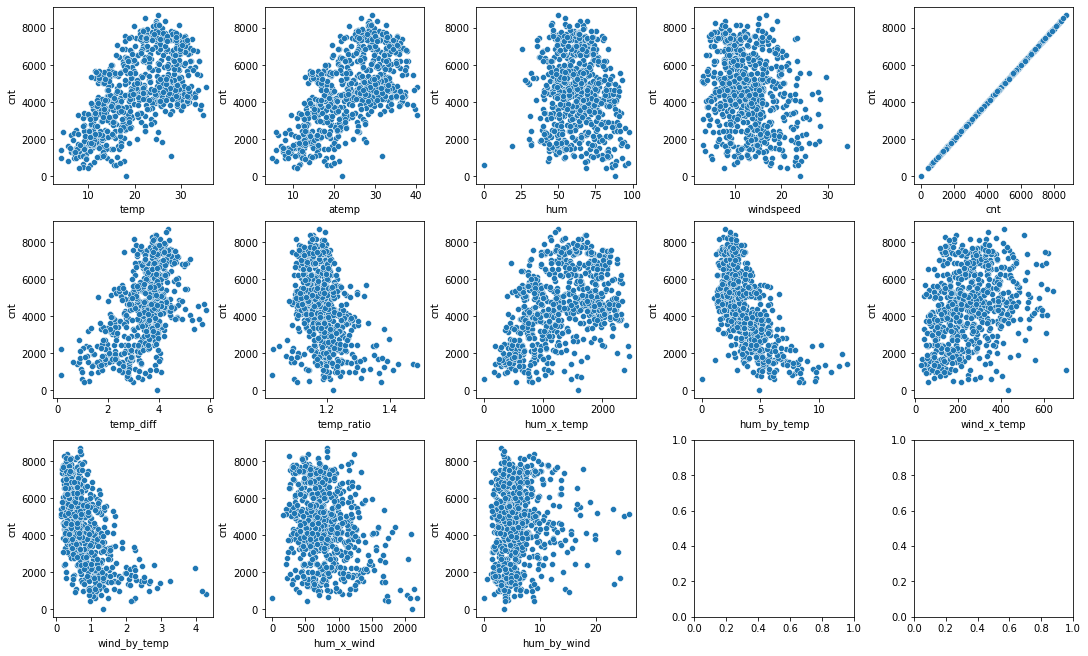

In [16]:
# distributions of continous vars
fig, ax = plt.subplots(3, 5, figsize=[15, 9], constrained_layout=True)
plot_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'temp_diff', 'temp_ratio', 
             'hum_x_temp', 'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind', 'hum_by_wind']
for idx, col in enumerate(plot_cols):
    sns.scatterplot(data=df_data.loc[df_data['temp_ratio']>0.5], x=col, y='cnt', ax=ax[idx//5, idx%5])
pass;

#### Continous - yr

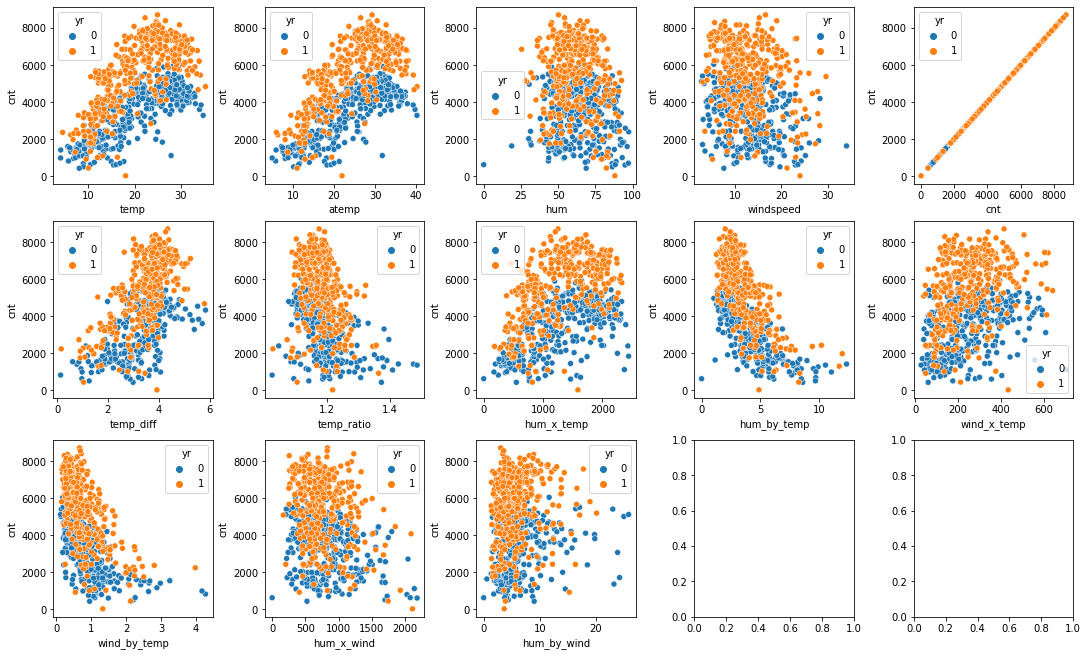

In [17]:
# distributions of continous vars by yr
fig, ax = plt.subplots(3, 5, figsize=[15, 9], constrained_layout=True)
plot_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'temp_diff', 'temp_ratio', 
             'hum_x_temp', 'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind', 'hum_by_wind']
for idx, col in enumerate(plot_cols):
    sns.scatterplot(data=df_data, x=col, y='cnt', hue='yr', ax=ax[idx//5, idx%5])
pass;

#### Continous - season

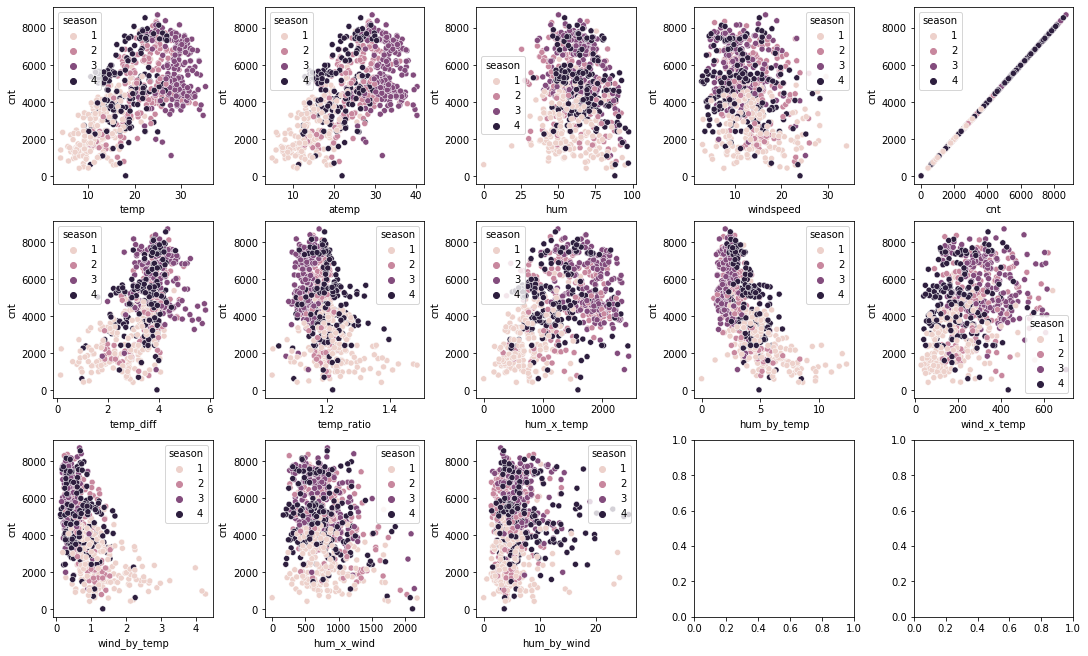

In [18]:
# distributions of continous vars by season
fig, ax = plt.subplots(3, 5, figsize=[15, 9], constrained_layout=True)
plot_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'temp_diff', 'temp_ratio', 
             'hum_x_temp', 'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind', 'hum_by_wind']
for idx, col in enumerate(plot_cols):
    sns.scatterplot(data=df_data, x=col, y='cnt', hue='season', ax=ax[idx//5, idx%5])
pass;

#### Continous - weathersit

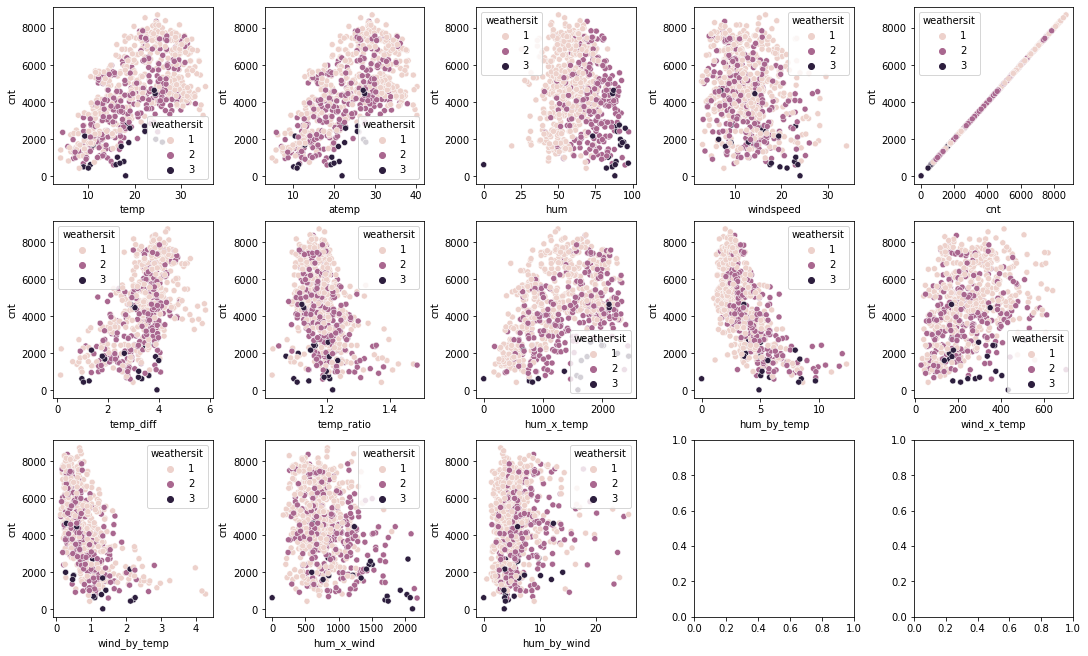

In [19]:
# distributions of continous vars by weathersit
fig, ax = plt.subplots(3, 5, figsize=[15, 9], constrained_layout=True)
plot_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'temp_diff', 'temp_ratio', 
             'hum_x_temp', 'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind', 'hum_by_wind']
for idx, col in enumerate(plot_cols):
    sns.scatterplot(data=df_data, x=col, y='cnt', hue='weathersit', ax=ax[idx//5, idx%5])
pass;

#### Categorical

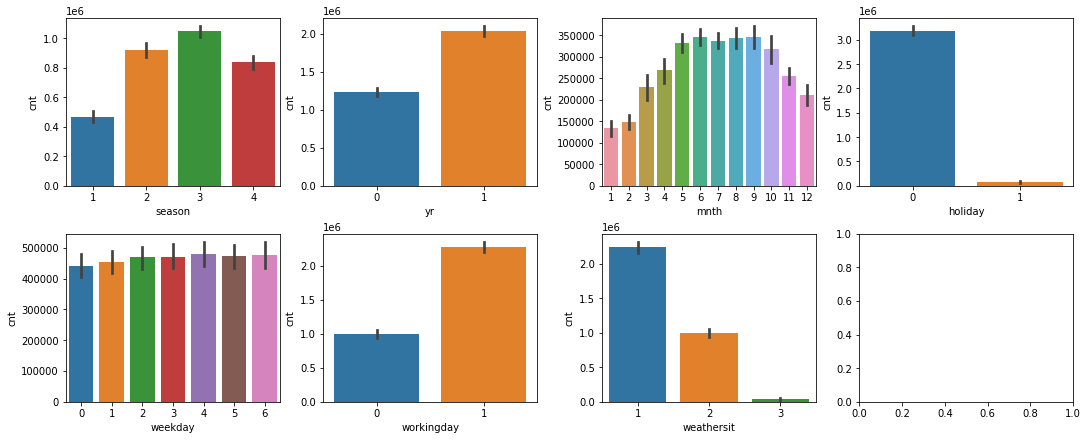

In [20]:
# total cnt for categorical vars
fig, ax = plt.subplots(2, 4, figsize=[15, 6], constrained_layout=True)
plot_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
for idx, col in enumerate(plot_cols):
    sns.barplot(data=df_data, x=col, y='cnt', estimator=np.sum, ax=ax[idx//4, idx%4])
pass;

#### Continous Binned

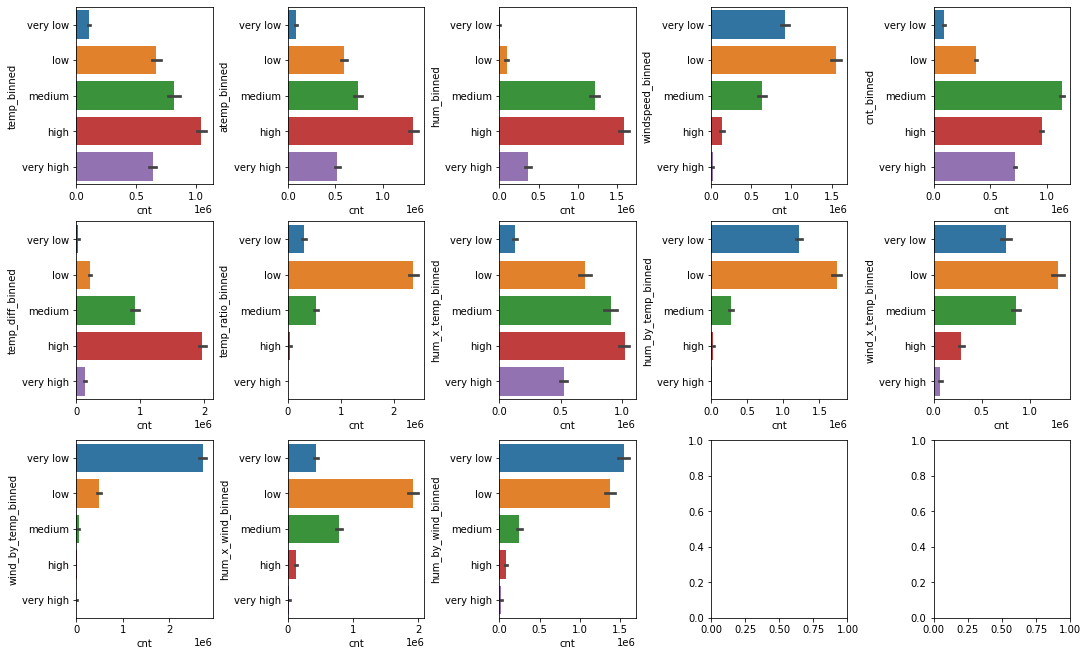

In [21]:
# total cnt for binned vars
fig, ax = plt.subplots(3, 5, figsize=[15, 9], constrained_layout=True)
plot_cols = ['temp_binned', 'atemp_binned', 'hum_binned',
       'windspeed_binned', 'cnt_binned', 'temp_diff_binned',
       'temp_ratio_binned', 'hum_x_temp_binned', 'hum_by_temp_binned',
       'wind_x_temp_binned', 'wind_by_temp_binned', 'hum_x_wind_binned',
       'hum_by_wind_binned']
for idx, col in enumerate(plot_cols):
    sns.barplot(data=df_data, y=col, x='cnt', estimator=np.sum, orient='h', ax=ax[idx//5, idx%5])
pass;

In [22]:
df_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,temp_diff,temp_ratio,hum_x_temp,hum_by_temp,wind_x_temp,wind_by_temp,hum_x_wind,hum_by_wind,temp_binned,atemp_binned,hum_binned,windspeed_binned,cnt_binned,temp_diff_binned,temp_ratio_binned,hum_x_temp_binned,hum_by_temp_binned,wind_x_temp_binned,wind_by_temp_binned,hum_x_wind_binned,hum_by_wind_binned
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,4.070403,1.288459,1137.098617,5.710734,151.689940,0.761817,866.260966,7.496203,low,low,very high,low,very low,high,medium,medium,medium,very low,very low,low,low
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,2.784352,1.186837,1037.350473,4.670910,248.159746,1.117397,1159.131938,4.180172,low,low,high,medium,very low,medium,low,medium,low,low,low,medium,very low
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1.419326,1.176294,352.045169,5.431339,133.940831,2.066434,727.478103,2.628363,very low,very low,medium,medium,very low,low,low,very low,medium,very low,medium,low,very low
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,2.406100,1.293427,484.156700,7.200427,88.066622,1.309736,634.117271,5.497619,very low,very low,high,low,very low,low,medium,very low,medium,very low,low,low,low
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,2.158263,1.231941,406.598844,4.695818,116.522969,1.345726,547.170664,3.489431,very low,very low,medium,low,very low,low,medium,very low,low,very low,low,low,very low


In [23]:
df_data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'temp_diff', 'temp_ratio', 'hum_x_temp',
       'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind',
       'hum_by_wind', 'temp_binned', 'atemp_binned', 'hum_binned',
       'windspeed_binned', 'cnt_binned', 'temp_diff_binned',
       'temp_ratio_binned', 'hum_x_temp_binned', 'hum_by_temp_binned',
       'wind_x_temp_binned', 'wind_by_temp_binned', 'hum_x_wind_binned',
       'hum_by_wind_binned'],
      dtype='object')

## Modelling

#### Split Train Test

In [24]:
df_train, df_test = train_test_split(df_data, test_size = 0.2, random_state = 123)

In [25]:
df_train.shape
df_test.shape

(579, 37)

(145, 37)

#### Scale Continous Vars

In [26]:
# scale continous values
scale_cols = ['temp', 'atemp', 'hum', 'windspeed', 'temp_diff', 'temp_ratio', 'hum_x_temp', 
              'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind', 'hum_by_wind',]
scaler = MinMaxScaler()
# scaler = StandardScaler()

# fit
scaler = scaler.fit(df_train[scale_cols])

# transform
scaled_cols = [f'{x}_scaled' for x in scale_cols]
df_train[scaled_cols] = scaler.transform(df_train[scale_cols])

df_train.shape
df_train.head()

(579, 49)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,temp_diff,temp_ratio,hum_x_temp,hum_by_temp,wind_x_temp,wind_by_temp,hum_x_wind,hum_by_wind,temp_binned,atemp_binned,hum_binned,windspeed_binned,cnt_binned,temp_diff_binned,temp_ratio_binned,hum_x_temp_binned,hum_by_temp_binned,wind_x_temp_binned,wind_by_temp_binned,hum_x_wind_binned,hum_by_wind_binned,temp_scaled,atemp_scaled,hum_scaled,windspeed_scaled,temp_diff_scaled,temp_ratio_scaled,hum_x_temp_scaled,hum_by_temp_scaled,wind_x_temp_scaled,wind_by_temp_scaled,hum_x_wind_scaled,hum_by_wind_scaled
173,174,23-06-2018,3,0,6,0,4,1,2,29.861653,34.69165,70.3333,15.999868,746,4044,4790,4.829997,1.161746,2100.268599,2.355305,477.782506,0.535800,1125.323516,4.395868,very high,very high,high,medium,medium,very high,low,very high,very low,high,very low,medium,very low,0.825740,0.842679,0.723222,0.492161,0.822774,0.296414,0.860071,0.191257,0.667647,0.099814,0.515962,0.169807
232,233,21-08-2018,3,0,8,0,0,0,1,29.144153,33.77625,77.0000,16.666518,1249,2624,3873,4.632097,1.158937,2244.099781,2.642039,485.731551,0.571865,1283.321886,4.620041,very high,very high,high,medium,medium,high,low,very high,low,high,very low,medium,very low,0.802869,0.816750,0.791774,0.517083,0.788078,0.290363,0.918971,0.214540,0.679449,0.108495,0.588404,0.178466
608,609,01-09-2019,3,1,9,0,6,0,2,30.886653,35.13270,63.8333,7.583529,2352,3788,6140,4.246047,1.137472,1971.596987,2.066695,234.229829,0.245528,484.081682,8.417361,very high,very high,high,very low,high,high,low,very high,very low,low,very low,low,low,0.858414,0.855172,0.656384,0.177536,0.720394,0.244114,0.807380,0.167821,0.306050,0.029948,0.221952,0.325152
462,463,08-04-2019,2,1,4,0,0,0,1,20.500000,24.62125,27.5833,15.583932,2230,2939,5169,4.121250,1.201037,565.457650,1.345527,319.470606,0.760192,429.856272,1.769983,medium,medium,low,medium,medium,high,low,low,very low,medium,very low,very low,very low,0.527322,0.557429,0.283633,0.476613,0.698515,0.381070,0.231558,0.109260,0.432605,0.153824,0.197089,0.068372
165,166,15-06-2018,2,0,6,0,3,1,1,25.693347,29.38770,47.1667,11.250104,769,4411,5180,3.694353,1.143786,1211.870390,1.835755,289.052826,0.437861,530.630280,4.192557,high,high,medium,low,medium,high,low,medium,very low,low,very low,low,very low,0.692869,0.692442,0.485005,0.314602,0.623670,0.257719,0.496267,0.149068,0.387444,0.076241,0.243294,0.161953


#### Get Dummy Columns for Categorical Vars

In [27]:
# cleaning only weathersit and keeping others same 
# as other categorical columns have an ordinal nature
df_train = pd.concat([df_train, pd.get_dummies(df_train['weathersit'], drop_first=True, prefix='weathersit')], axis=1)
df_train = pd.concat([df_train, pd.get_dummies(df_train['season'], drop_first=True, prefix='season')], axis=1)
df_train = pd.concat([df_train, pd.get_dummies(df_train['mnth'], drop_first=True, prefix='mnth')], axis=1)
df_train = pd.concat([df_train, pd.get_dummies(df_train['weekday'], drop_first=True, prefix='weekday')], axis=1)
df_train.shape
df_train.head()

(579, 71)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,temp_diff,temp_ratio,hum_x_temp,hum_by_temp,wind_x_temp,wind_by_temp,hum_x_wind,hum_by_wind,temp_binned,atemp_binned,hum_binned,windspeed_binned,cnt_binned,temp_diff_binned,temp_ratio_binned,hum_x_temp_binned,hum_by_temp_binned,wind_x_temp_binned,wind_by_temp_binned,hum_x_wind_binned,hum_by_wind_binned,temp_scaled,atemp_scaled,hum_scaled,windspeed_scaled,temp_diff_scaled,temp_ratio_scaled,hum_x_temp_scaled,hum_by_temp_scaled,wind_x_temp_scaled,wind_by_temp_scaled,hum_x_wind_scaled,hum_by_wind_scaled,weathersit_2,weathersit_3,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
173,174,23-06-2018,3,0,6,0,4,1,2,29.861653,34.69165,70.3333,15.999868,746,4044,4790,4.829997,1.161746,2100.268599,2.355305,477.782506,0.535800,1125.323516,4.395868,very high,very high,high,medium,medium,very high,low,very high,very low,high,very low,medium,very low,0.825740,0.842679,0.723222,0.492161,0.822774,0.296414,0.860071,0.191257,0.667647,0.099814,0.515962,0.169807,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
232,233,21-08-2018,3,0,8,0,0,0,1,29.144153,33.77625,77.0000,16.666518,1249,2624,3873,4.632097,1.158937,2244.099781,2.642039,485.731551,0.571865,1283.321886,4.620041,very high,very high,high,medium,medium,high,low,very high,low,high,very low,medium,very low,0.802869,0.816750,0.791774,0.517083,0.788078,0.290363,0.918971,0.214540,0.679449,0.108495,0.588404,0.178466,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
608,609,01-09-2019,3,1,9,0,6,0,2,30.886653,35.13270,63.8333,7.583529,2352,3788,6140,4.246047,1.137472,1971.596987,2.066695,234.229829,0.245528,484.081682,8.417361,very high,very high,high,very low,high,high,low,very high,very low,low,very low,low,low,0.858414,0.855172,0.656384,0.177536,0.720394,0.244114,0.807380,0.167821,0.306050,0.029948,0.221952,0.325152,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
462,463,08-04-2019,2,1,4,0,0,0,1,20.500000,24.62125,27.5833,15.583932,2230,2939,5169,4.121250,1.201037,565.457650,1.345527,319.470606,0.760192,429.856272,1.769983,medium,medium,low,medium,medium,high,low,low,very low,medium,very low,very low,very low,0.527322,0.557429,0.283633,0.476613,0.698515,0.381070,0.231558,0.109260,0.432605,0.153824,0.197089,0.068372,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
165,166,15-06-2018,2,0,6,0,3,1,1,25.693347,29.38770,47.1667,11.250104,769,4411,5180,3.694353,1.143786,1211.870390,1.835755,289.052826,0.437861,530.630280,4.192557,high,high,medium,low,medium,high,low,medium,very low,low,very low,low,very low,0.692869,0.692442,0.485005,0.314602,0.623670,0.257719,0.496267,0.149068,0.387444,0.076241,0.243294,0.161953,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [28]:
df_train.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'temp_diff', 'temp_ratio', 'hum_x_temp',
       'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind',
       'hum_by_wind', 'temp_binned', 'atemp_binned', 'hum_binned',
       'windspeed_binned', 'cnt_binned', 'temp_diff_binned',
       'temp_ratio_binned', 'hum_x_temp_binned', 'hum_by_temp_binned',
       'wind_x_temp_binned', 'wind_by_temp_binned', 'hum_x_wind_binned',
       'hum_by_wind_binned', 'temp_scaled', 'atemp_scaled', 'hum_scaled',
       'windspeed_scaled', 'temp_diff_scaled', 'temp_ratio_scaled',
       'hum_x_temp_scaled', 'hum_by_temp_scaled', 'wind_x_temp_scaled',
       'wind_by_temp_scaled', 'hum_x_wind_scaled', 'hum_by_wind_scaled',
       'weathersit_2', 'weathersit_3', 'season_2', 'season_3', 'season_4',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8

#### Define Feature and Target cols

In [29]:
feature_cols_all = [
       'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'temp_diff', 'temp_ratio', 'hum_x_temp',
       'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind',
       'hum_by_wind', 'temp_scaled', 'atemp_scaled', 'hum_scaled',
       'windspeed_scaled', 'temp_diff_scaled', 'hum_x_temp_scaled',
       'hum_by_temp_scaled', 'wind_x_temp_scaled', 'wind_by_temp_scaled',
       'weathersit_2', 'weathersit_3', 'season_2', 'season_3', 'season_4',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'
]

feature_cols_label_nonscaled = [
       'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'temp_diff', 'temp_ratio', 'hum_x_temp',
       'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind',
       'hum_by_wind'
]

feature_cols_label_scaled = [
       'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp_scaled', 'atemp_scaled', 'hum_scaled',
       'windspeed_scaled', 'temp_diff_scaled', 'hum_x_temp_scaled',
       'hum_by_temp_scaled', 'wind_x_temp_scaled', 'wind_by_temp_scaled'
]

feature_cols_onehot_nonscaled = [
       'yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'temp_diff', 'temp_ratio', 'hum_x_temp', 'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind',
       'hum_by_wind', 'weathersit_2', 'weathersit_3', 'season_2', 'season_3', 'season_4',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'
]

feature_cols_onehot_scaled = [
       'yr', 'holiday', 'workingday', 'temp_scaled', 'atemp_scaled', 'hum_scaled',
       'windspeed_scaled', 'temp_diff_scaled', 'temp_ratio_scaled', 'hum_x_temp_scaled',
       'hum_by_temp_scaled', 'wind_x_temp_scaled', 'wind_by_temp_scaled', 'hum_x_wind_scaled', 'hum_by_wind_scaled',
       'weathersit_2', 'weathersit_3', 'season_2', 'season_3', 'season_4',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'
]


high_correl_vars = ['temp', 'temp_scaled']

feature_cols = [x for x in feature_cols_onehot_scaled if x not in high_correl_vars]
target_cols = ['cnt']

#### SKLearn Linear Regression with RFE - Coarse Model

In [30]:
# fit model
model_skl = LinearRegression()
model_skl.fit(df_train[feature_cols], df_train[target_cols])

# running RFE
rfe = RFE(model_skl, n_features_to_select=15)
rfe = rfe.fit(df_train[feature_cols], df_train[target_cols])

# RFE output
pd.DataFrame(zip(df_train[feature_cols].columns, rfe.support_, rfe.ranking_),
             columns=['column', 'support', 'ranking'])

LinearRegression()

,column,support,ranking
0,yr,True,1
1,holiday,False,15
2,workingday,False,7
3,atemp_scaled,True,1
4,hum_scaled,False,4
5,windspeed_scaled,True,1
6,temp_diff_scaled,True,1
7,temp_ratio_scaled,True,1
8,hum_x_temp_scaled,True,1
9,hum_by_temp_scaled,True,1


#### Statsmodel - Finetune Model

In [31]:
# get rfe cols that have True mask
rfe_cols = df_train[feature_cols].columns[rfe.support_]

# manually drop cols with high p-value or VIF
drop_cols = ['temp_diff_scaled', 'temp_ratio_scaled', 'wind_x_temp_scaled', 'wind_by_temp_scaled', 
             'atemp_scaled', 'mnth_7', 'hum_x_temp_scaled']
rfe_cols = [x for x in rfe_cols if x not in drop_cols]

rfe_cols

['yr',
 'windspeed_scaled',
 'hum_by_temp_scaled',
 'weathersit_3',
 'season_2',
 'season_3',
 'season_4',
 'mnth_9']

In [32]:
# filter cols
X_train, y_train = df_train[rfe_cols], df_train[target_cols]

# add constant
X_train_lm = sm.add_constant(X_train)

# fit model
model_sm = sm.OLS(y_train, X_train_lm).fit()

# metrics
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     306.0
Date:                Sun, 01 Aug 2021   Prob (F-statistic):          1.03e-200
Time:                        15:54:02   Log-Likelihood:                -4719.9
No. Observations:                 579   AIC:                             9458.
Df Residuals:                     570   BIC:                             9497.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4520.9241    195.321     23.146      0.000    4137.287    4904.561
yr                  1931.6826     71.796     26.905      0.000    1790.665    2072.700
windspeed_scaled   -1406.6212    196.956     -7.142      0.000   -1793.469   -1019.773
hum_by_temp_scaled -5214.5661    330.888    -15.759      0.000   -5864.474   -4564.658
weathersit_3       -1373.2893    229.238     -5.991      0.000   -1823.544    -923.034
season_2            1357.2292    115.128     11.789      0.000    1131.103    1583.355
season_3            1441.6772    135.716     10.623      0.000    1175.113    1708.241
season_4            1386.5848    109.260     12.691      0.000    1171.984    1601.185
mnth_9               596.1859    136.621      4.364      0.000     327.844     864.528
==============================================================================
Omnibus:                       44.785   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.593
Skew:                          -0.556   Prob(JB):                     7.73e-16
Kurtosis:                       4.283   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF

In [33]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,windspeed_scaled,3.86
2,hum_by_temp_scaled,3.13
0,yr,1.88
5,season_3,1.70
4,season_2,1.64
6,season_4,1.53
7,mnth_9,1.28
3,weathersit_3,1.07


#### Make Prediction

In [34]:
y_train_pred = model_sm.predict(X_train_lm)
y_train_pred.shape

(579,)

#### Residuals

<AxesSubplot:ylabel='Density'>

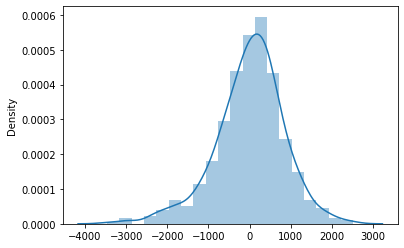

In [35]:
# check normality
residuals = y_train.values - y_train_pred.values.reshape(-1, 1)
sns.distplot(residuals, bins = 20)

<AxesSubplot:>

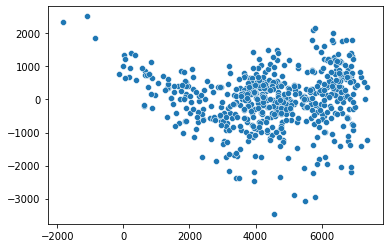

In [36]:
# check homoscedasticity
sns.scatterplot(x=y_train_pred, y=residuals.reshape(-1))

There is some pattern not being captured by the model in cnt<2000 area. May have to add some non-linear features.

## Test Prediction

#### Scale Continous Vars

In [37]:
# scale continous values
scale_cols = ['temp', 'atemp', 'hum', 'windspeed', 'temp_diff', 'temp_ratio', 'hum_x_temp', 
              'hum_by_temp', 'wind_x_temp', 'wind_by_temp', 'hum_x_wind', 'hum_by_wind',]

# transform
scaled_cols = [f'{x}_scaled' for x in scale_cols]
df_test[scaled_cols] = scaler.transform(df_test[scale_cols])

df_test.shape
df_test.head()

(145, 49)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,temp_diff,temp_ratio,hum_x_temp,hum_by_temp,wind_x_temp,wind_by_temp,hum_x_wind,hum_by_wind,temp_binned,atemp_binned,hum_binned,windspeed_binned,cnt_binned,temp_diff_binned,temp_ratio_binned,hum_x_temp_binned,hum_by_temp_binned,wind_x_temp_binned,wind_by_temp_binned,hum_x_wind_binned,hum_by_wind_binned,temp_scaled,atemp_scaled,hum_scaled,windspeed_scaled,temp_diff_scaled,temp_ratio_scaled,hum_x_temp_scaled,hum_by_temp_scaled,wind_x_temp_scaled,wind_by_temp_scaled,hum_x_wind_scaled,hum_by_wind_scaled
170,171,20-06-2018,2,0,6,0,1,1,2,26.035000,29.76730,74.6250,10.416825,699,3311,4010,3.732300,1.143357,1942.861875,2.866334,271.202039,0.400109,777.355566,7.163891,high,high,high,low,medium,high,low,high,low,low,very low,low,low,0.703760,0.703194,0.767352,0.283452,0.630323,0.256794,0.795612,0.232753,0.360941,0.067154,0.356418,0.276732
55,56,25-02-2018,1,0,2,0,5,1,2,14.938268,17.52305,71.2174,23.218113,120,1341,1461,2.584782,1.173031,1063.864607,4.767447,346.838394,1.554271,1653.533641,3.067321,low,low,high,high,very low,medium,low,medium,low,medium,low,high,very low,0.350033,0.356368,0.732313,0.761999,0.429136,0.320729,0.435658,0.387129,0.473237,0.344954,0.758146,0.118487
500,501,16-05-2019,2,1,5,0,3,1,1,26.103347,29.79875,69.7917,8.208304,991,6433,7424,3.695403,1.141568,1821.796963,2.673669,214.264208,0.314454,572.871490,8.502573,high,high,high,very low,very high,high,low,high,low,low,very low,low,low,0.705938,0.704085,0.717652,0.200892,0.623854,0.252940,0.746036,0.217109,0.276407,0.046538,0.262662,0.328443
661,662,24-10-2019,4,1,10,0,3,1,1,24.087500,27.93605,63.6250,4.876206,795,6898,7693,3.848550,1.159774,1532.567187,2.641412,117.455622,0.202437,310.248632,13.048053,high,high,high,very low,very high,high,low,high,low,very low,very low,very low,medium,0.641680,0.651323,0.654242,0.076329,0.650704,0.292165,0.627595,0.214489,0.132677,0.019576,0.142249,0.504029
536,537,21-06-2019,3,1,6,0,4,1,1,33.039153,37.62710,56.7917,7.958729,778,5127,5905,4.587947,1.138864,1876.349665,1.718921,262.949665,0.240888,451.989750,7.135775,very high,very high,medium,very low,high,high,low,high,very low,low,very low,low,low,0.927028,0.925828,0.583976,0.191562,0.780337,0.247113,0.768375,0.139581,0.348689,0.028831,0.207238,0.275646


#### Get Dummy Columns for Categorical Vars

In [38]:
# cleaning only weathersit and keeping others same 
# as other categorical columns have an ordinal nature
df_test = pd.concat([df_test, pd.get_dummies(df_test['weathersit'], drop_first=True, prefix='weathersit')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['season'], drop_first=True, prefix='season')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['mnth'], drop_first=True, prefix='mnth')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['weekday'], drop_first=True, prefix='weekday')], axis=1)
df_test.shape
df_test.head()

(145, 71)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,temp_diff,temp_ratio,hum_x_temp,hum_by_temp,wind_x_temp,wind_by_temp,hum_x_wind,hum_by_wind,temp_binned,atemp_binned,hum_binned,windspeed_binned,cnt_binned,temp_diff_binned,temp_ratio_binned,hum_x_temp_binned,hum_by_temp_binned,wind_x_temp_binned,wind_by_temp_binned,hum_x_wind_binned,hum_by_wind_binned,temp_scaled,atemp_scaled,hum_scaled,windspeed_scaled,temp_diff_scaled,temp_ratio_scaled,hum_x_temp_scaled,hum_by_temp_scaled,wind_x_temp_scaled,wind_by_temp_scaled,hum_x_wind_scaled,hum_by_wind_scaled,weathersit_2,weathersit_3,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
170,171,20-06-2018,2,0,6,0,1,1,2,26.035000,29.76730,74.6250,10.416825,699,3311,4010,3.732300,1.143357,1942.861875,2.866334,271.202039,0.400109,777.355566,7.163891,high,high,high,low,medium,high,low,high,low,low,very low,low,low,0.703760,0.703194,0.767352,0.283452,0.630323,0.256794,0.795612,0.232753,0.360941,0.067154,0.356418,0.276732,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
55,56,25-02-2018,1,0,2,0,5,1,2,14.938268,17.52305,71.2174,23.218113,120,1341,1461,2.584782,1.173031,1063.864607,4.767447,346.838394,1.554271,1653.533641,3.067321,low,low,high,high,very low,medium,low,medium,low,medium,low,high,very low,0.350033,0.356368,0.732313,0.761999,0.429136,0.320729,0.435658,0.387129,0.473237,0.344954,0.758146,0.118487,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
500,501,16-05-2019,2,1,5,0,3,1,1,26.103347,29.79875,69.7917,8.208304,991,6433,7424,3.695403,1.141568,1821.796963,2.673669,214.264208,0.314454,572.871490,8.502573,high,high,high,very low,very high,high,low,high,low,low,very low,low,low,0.705938,0.704085,0.717652,0.200892,0.623854,0.252940,0.746036,0.217109,0.276407,0.046538,0.262662,0.328443,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
661,662,24-10-2019,4,1,10,0,3,1,1,24.087500,27.93605,63.6250,4.876206,795,6898,7693,3.848550,1.159774,1532.567187,2.641412,117.455622,0.202437,310.248632,13.048053,high,high,high,very low,very high,high,low,high,low,very low,very low,very low,medium,0.641680,0.651323,0.654242,0.076329,0.650704,0.292165,0.627595,0.214489,0.132677,0.019576,0.142249,0.504029,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
536,537,21-06-2019,3,1,6,0,4,1,1,33.039153,37.62710,56.7917,7.958729,778,5127,5905,4.587947,1.138864,1876.349665,1.718921,262.949665,0.240888,451.989750,7.135775,very high,very high,medium,very low,high,high,low,high,very low,low,very low,low,low,0.927028,0.925828,0.583976,0.191562,0.780337,0.247113,0.768375,0.139581,0.348689,0.028831,0.207238,0.275646,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


#### Make Prediction

In [39]:
# filter cols
X_test, y_test = df_test[rfe_cols], df_test[target_cols]

# add constant
X_test_lm = sm.add_constant(X_test)

In [40]:
# get preds
y_test_pred = model_sm.predict(X_test_lm)
y_test_pred.shape

(145,)

#### Score

In [41]:
print(f'R2 score for Test Data: {r2_score(y_test.values.reshape(-1), y_test_pred)}')

R2 score for Test Data: 0.7901261593582585


## Model Interpretation

The final model can be represented as: 

In [62]:
print('cnt = \n' + ' + \n'.join([f'({round(coef, 2)} * {column})' for column, coef in zip(model_sm.params.index, model_sm.params.values)]))

cnt = 
(4520.92 * const) + 
(1931.68 * yr) + 
(-1406.62 * windspeed_scaled) + 
(-5214.57 * hum_by_temp_scaled) + 
(-1373.29 * weathersit_3) + 
(1357.23 * season_2) + 
(1441.68 * season_3) + 
(1386.58 * season_4) + 
(596.19 * mnth_9)


where const = 1

And the model explains ~80% of the variance within `cnt` variable.